In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [112]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activations, output_size, use_bn, dropout_rates):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_size

        for i, (out_dim, activation) in enumerate(zip(hidden_layers, activations)):
            layers.append(nn.Linear(in_dim, out_dim))

            if use_bn[i]:
                layers.append(nn.BatchNorm1d(out_dim))

            if activation.lower() == 'relu':
                layers.append(nn.ReLU())
            elif activation.lower() == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation.lower() == 'tanh':
                layers.append(nn.Tanh())

            if dropout_rates[i] > 0:
                layers.append(nn.Dropout(dropout_rates[i]))

            in_dim = out_dim

        layers.append(nn.Linear(in_dim, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [113]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [114]:
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [115]:
input_size = X_train.shape[1]
hidden_layers = [10, 20, 10]
activations = ['relu', 'relu', 'relu']
output_size = 3
use_bn = [True, False, True]
dropout_rates = [0.2, 0.3, 0.1]

model = MLP(input_size, hidden_layers, activations, output_size, use_bn, dropout_rates)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')



Epoch [10/100], Loss: 0.8401, Train Accuracy: 65.83%, Test Accuracy: 90.00%
Epoch [20/100], Loss: 0.6755, Train Accuracy: 78.33%, Test Accuracy: 96.67%
Epoch [30/100], Loss: 0.5463, Train Accuracy: 83.33%, Test Accuracy: 96.67%
Epoch [40/100], Loss: 0.5531, Train Accuracy: 81.67%, Test Accuracy: 96.67%
Epoch [50/100], Loss: 0.4381, Train Accuracy: 86.67%, Test Accuracy: 96.67%
Epoch [60/100], Loss: 0.4891, Train Accuracy: 85.00%, Test Accuracy: 100.00%
Epoch [70/100], Loss: 0.3749, Train Accuracy: 83.33%, Test Accuracy: 100.00%
Epoch [80/100], Loss: 0.4259, Train Accuracy: 80.83%, Test Accuracy: 100.00%
Epoch [90/100], Loss: 0.3892, Train Accuracy: 86.67%, Test Accuracy: 100.00%
Epoch [100/100], Loss: 0.3199, Train Accuracy: 88.33%, Test Accuracy: 100.00%


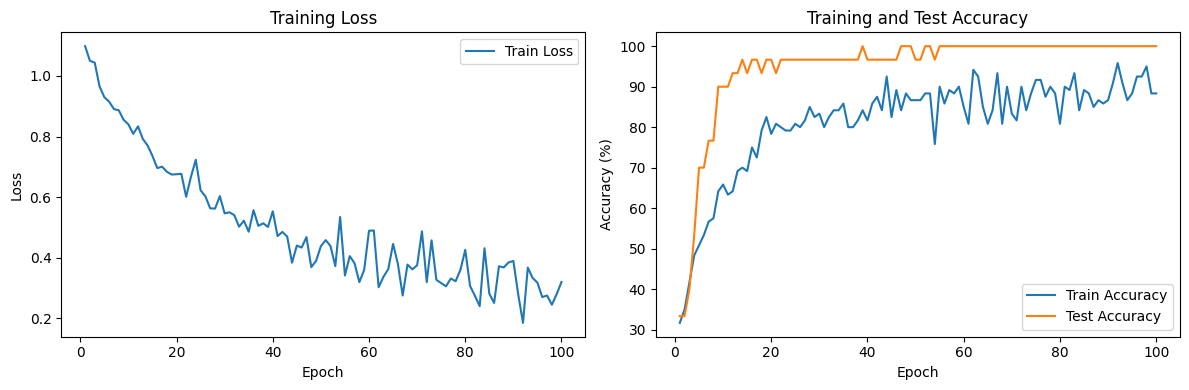

Accuracy of the model on the test set: 100.00%


In [116]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')